# Homework: Basic Artificial Neural Networks

The goal of this homework is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

This homework requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook  - ***13 points***
- homework_modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework) 
- homework_differentiation.ipynb -  ***2 points***

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `Modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run homework_modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

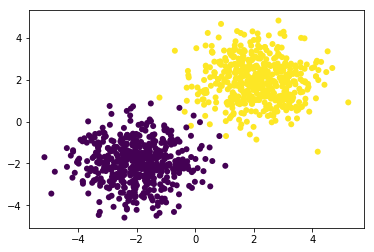

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [4]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [5]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [6]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

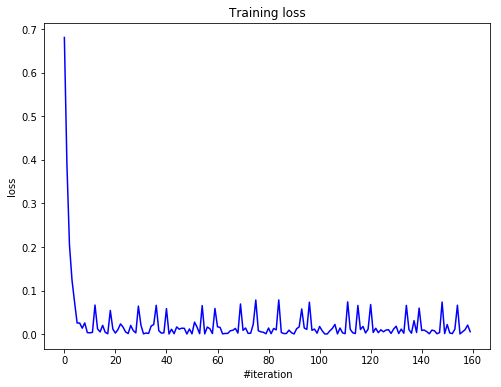

Current loss: 0.005442


In [7]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [8]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

One-hot encode the labels first.

In [9]:
# Your code goes here. ################################################
from sklearn.preprocessing import OneHotEncoder
one_hot_obj = OneHotEncoder()
one_hot_obj.fit(y_train.reshape(-1, 1))
y_train = one_hot_obj.transform(y_train.reshape(-1, 1)).toarray()
y_val = one_hot_obj.transform(y_val.reshape(-1, 1)).toarray()
y_test = one_hot_obj.transform(y_test.reshape(-1, 1)).toarray()

X_train_transformed = X_train.reshape((X_train.shape[0], X_train.shape[1]*X_train.shape[2]))
X_val_transformed = X_val.reshape((X_val.shape[0], X_val.shape[1]*X_val.shape[2]))
X_test_transformed = X_test.reshape((X_test.shape[0], X_test.shape[1]*X_test.shape[2]))

/home/dmitriy/MyEnv/other/skoltech/dl/env/lib/python3.5/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison. Write your personal opinion on the activation functions, think about computation times too. Plot the losses both from activation functions comparison comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking. ***2.5 points***
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions. Plot the losses both for the `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.  Does `BatchNormalization` help? ***2.5 points***

- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better? ***2.5 points***
- Increase the number of parameters in the network. Try inserting the Dropout layer. Compare the validation performance and the gap between test and validation performances for the two experiments (with and without Dropout). Compare the loss plots. Which one converges slower? ***2.5 points***


<class '__main__.ReLU'>
<class '__main__.ELU'>
<class '__main__.LeakyReLU'>
<class '__main__.SoftPlus'>


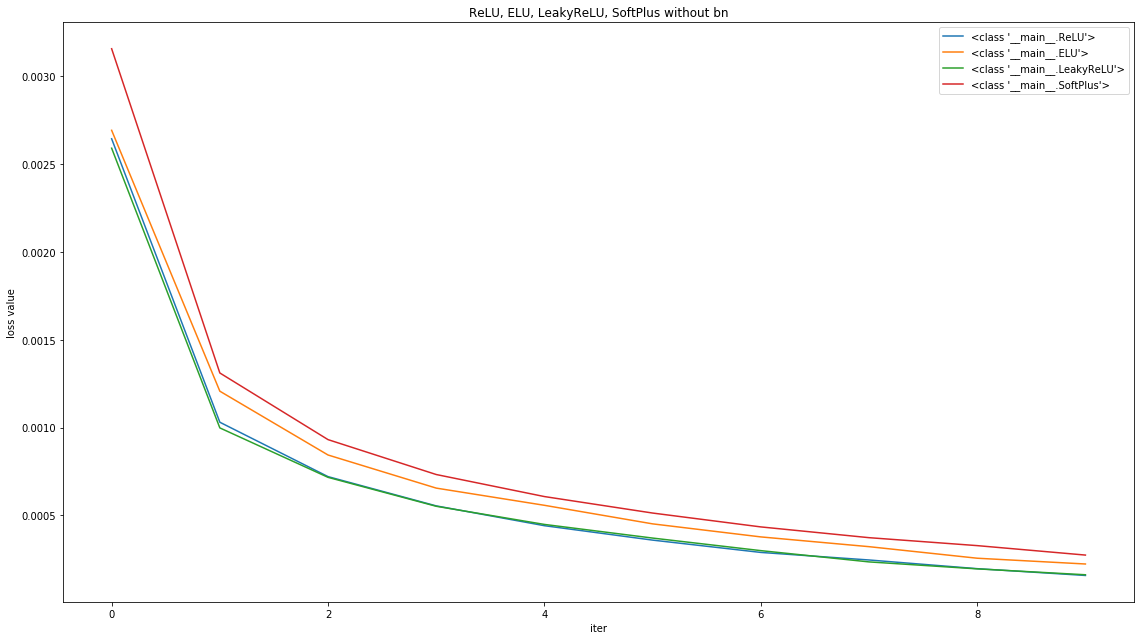

<class '__main__.ELU'>: mean epoch time is 2.3078617811203004
<class '__main__.ReLU'>: mean epoch time is 2.0504839181900025
<class '__main__.SoftPlus'>: mean epoch time is 2.6250363111495973
<class '__main__.LeakyReLU'>: mean epoch time is 1.9084004163742065
CPU times: user 3min 17s, sys: 2min 8s, total: 5min 26s
Wall time: 1min 29s


In [53]:
%%time
# Your code goes here. ################################################
import time

optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
activations_list = [ReLU, ELU, LeakyReLU, SoftPlus]
batch_size = 128

criterion = ClassNLLCriterion()
n_epoch = 10

X = X_train_transformed
y = y_train

epoch_times = {
               ReLU: [],
               ELU: [],
               LeakyReLU: [],
               SoftPlus: [],
              }

plt.figure(figsize=(16,9))

stats_without_bn = {
    ReLU: {},
    ELU: {},
    LeakyReLU: {}, 
    SoftPlus: {},
}

for a in activations_list:
    print(str(a))
    net = Sequential()
    net.add(Linear(X.shape[1], 100))
    net.add(a())        
    net.add(Linear(100, y.shape[1]))
    net.add(LogSoftMax())
    
    losses = []
    optimizer_state = {}
    
    for i in range(n_epoch):
        start = time.time()
        summary_loss = 0.0
        for x_batch, y_batch in get_batches((X, y), batch_size):
            net.zeroGradParameters()
            pred = net.forward(x_batch)
            loss = criterion.forward(pred, y_batch)
            summary_loss += loss
            dp = criterion.backward(pred, y_batch)
            net.backward(x_batch, dp)
            sgd_momentum(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)      
            
        end = time.time()
        losses.append(summary_loss / X.shape[0])
        epoch_times[a].append(end - start)
        
    label = str(a)
    plt.plot(losses, label = label)
    
    stats_without_bn[a]['losses'] = losses
    stats_without_bn[a]['epoch_times'] = epoch_times

plt.legend()
plt.title('ReLU, ELU, LeakyReLU, SoftPlus without bn')
plt.xlabel("epoch")
plt.ylabel("loss value")
plt.tight_layout()
plt.show()

for key,value in epoch_times.items():
    print("{}: mean epoch time is {}".format(key,np.mean(value)))


## Comments
- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions.
It seems like ReLU and LeakyReLU are the best in terms of loss, convergence and mean epoch time. Maybe I didn't see a big increase here because of not so deep network (Vanishing gradients problem is not a big deal here)

<class '__main__.ReLU'>
<class '__main__.ELU'>
<class '__main__.LeakyReLU'>
<class '__main__.SoftPlus'>
<class '__main__.ReLU'>
<class '__main__.ELU'>
<class '__main__.LeakyReLU'>
<class '__main__.SoftPlus'>


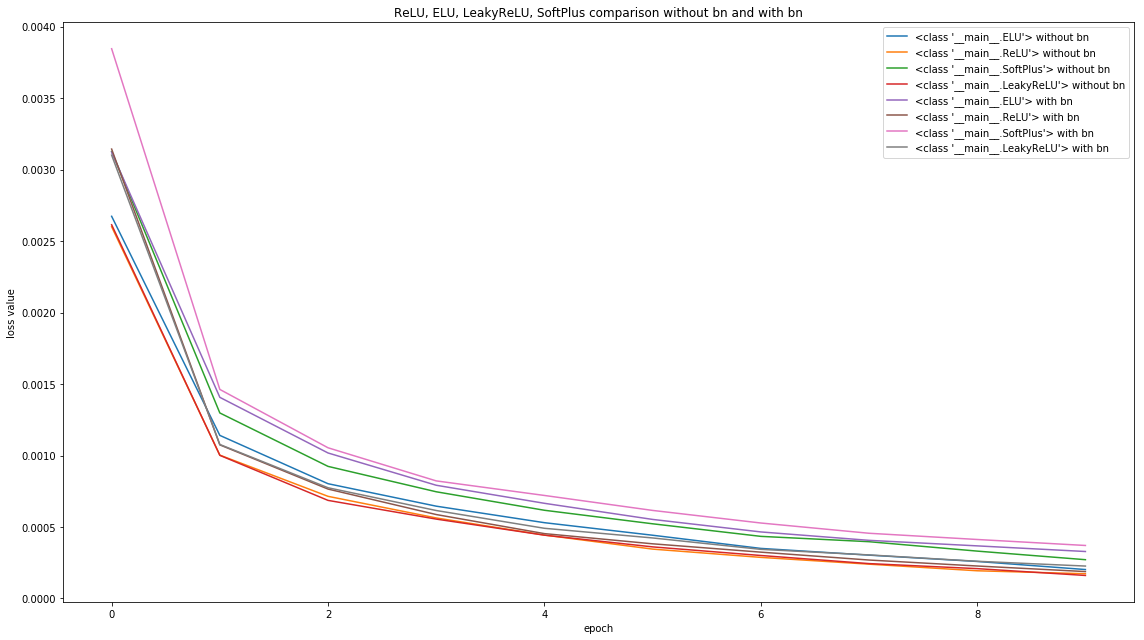

Without bn. <class '__main__.ELU'>: mean epoch time is 2.676194596290588
Without bn. <class '__main__.ReLU'>: mean epoch time is 2.7463569164276125
Without bn. <class '__main__.SoftPlus'>: mean epoch time is 2.6577165126800537
Without bn. <class '__main__.LeakyReLU'>: mean epoch time is 1.9343775272369386
With bn. <class '__main__.ELU'>: mean epoch time is 3.0554354190826416
With bn. <class '__main__.ReLU'>: mean epoch time is 2.7804574251174925
With bn. <class '__main__.SoftPlus'>: mean epoch time is 2.9918795347213747
With bn. <class '__main__.LeakyReLU'>: mean epoch time is 2.4978972911834716
CPU times: user 7min 27s, sys: 5min 18s, total: 12min 46s
Wall time: 3min 33s


In [64]:
%%time
# Your code goes here. ################################################
import time

optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
activations_list = [ReLU, ELU, LeakyReLU, SoftPlus]
batch_size = 128

criterion = ClassNLLCriterion()
n_epoch = 10

X = X_train_transformed
y = y_train

stats_without_bn = {
    ReLU: {},
    ELU: {},
    LeakyReLU: {}, 
    SoftPlus: {},
}

for a in activations_list:
    print(str(a))
    net = Sequential()
    net.add(Linear(X.shape[1], 100))
    net.add(a())        
    net.add(Linear(100, y.shape[1]))
    net.add(LogSoftMax())
    
    losses = []
    optimizer_state = {}
    epoch_times = []
    for i in range(n_epoch):
        start = time.time()
        summary_loss = 0.0
        for x_batch, y_batch in get_batches((X, y), batch_size):
            net.zeroGradParameters()
            pred = net.forward(x_batch)
            loss = criterion.forward(pred, y_batch)
            summary_loss += loss
            dp = criterion.backward(pred, y_batch)
            net.backward(x_batch, dp)
            sgd_momentum(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)      
            
        end = time.time()
        losses.append(summary_loss / X.shape[0])
        epoch_times.append(end - start)
    
    stats_without_bn[a]['losses'] = losses
    stats_without_bn[a]['epoch_times'] = epoch_times
    
    
stats_with_bn = {
    ReLU: {},
    ELU: {},
    LeakyReLU: {}, 
    SoftPlus: {},
}

for a in activations_list:
    print(str(a))
    net = Sequential()
    net.add(Linear(X.shape[1], 100))
    net.add(BatchNormalization())
    net.add(ChannelwiseScaling(100))
    net.add(a())        
    net.add(Linear(100, y.shape[1]))
    net.add(LogSoftMax())
    
    losses = []
    optimizer_state = {}
    epoch_times = []
    
    for i in range(n_epoch):
        start = time.time()
        summary_loss = 0.0
        for x_batch, y_batch in get_batches((X, y), batch_size):
            net.zeroGradParameters()
            pred = net.forward(x_batch)
            loss = criterion.forward(pred, y_batch)
            summary_loss += loss
            dp = criterion.backward(pred, y_batch)
            net.backward(x_batch, dp)
            sgd_momentum(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)      
            
        end = time.time()
        losses.append(summary_loss / X.shape[0])
        epoch_times.append(end - start)
    
    stats_with_bn[a]['losses'] = losses
    stats_with_bn[a]['epoch_times'] = epoch_times

    
plt.figure(figsize=(16,9))

for key,value in stats_without_bn.items():
    plt.plot(value['losses'], label=str(key) + ' without bn')

for key,value in stats_with_bn.items():
    plt.plot(value['losses'], label=str(key) + ' with bn')    
    
plt.legend()    
plt.title('ReLU, ELU, LeakyReLU, SoftPlus comparison without bn and with bn')
plt.xlabel("epoch")
plt.ylabel("loss value")
plt.tight_layout()
plt.show()

for key,value in stats_without_bn.items():
    print("Without bn. {}: mean epoch time is {}".format(key,np.mean(value['epoch_times'])))
    
for key,value in stats_with_bn.items():
    print("With bn. {}: mean epoch time is {}".format(key,np.mean(value['epoch_times'])))


## Comments
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions. Looking on the plot it seems like in general network converges faster with Batch Normalization. But for the best activations (ReLU and LeakyReLU) there is no difference in terms of loss. Again, maybe because of I've been lucky with network structure and with complexety of the task

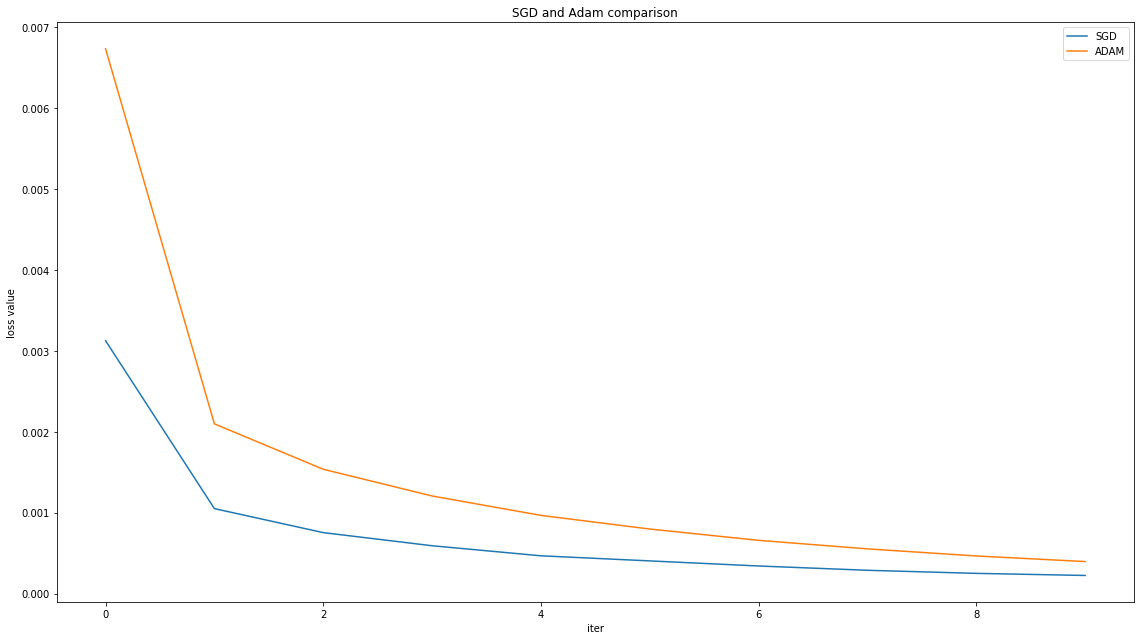

CPU times: user 2min 3s, sys: 1min 31s, total: 3min 34s
Wall time: 1min 1s


In [61]:
%%time
# Your code goes here. ################################################
import time

optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
batch_size = 128

criterion = ClassNLLCriterion()
n_epoch = 10

X = X_train_transformed
y = y_train

a = ReLU
net = Sequential()
net.add(Linear(X.shape[1], 100))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(100))
net.add(a())        
net.add(Linear(100, y.shape[1]))
net.add(LogSoftMax())

losses_sgd = []
times_sgd = []

optimizer_state = {}

for i in range(n_epoch):
    start = time.time()
    summary_loss = 0.0
    for x_batch, y_batch in get_batches((X, y), batch_size):
        net.zeroGradParameters()
        pred = net.forward(x_batch)
        loss = criterion.forward(pred, y_batch)
        summary_loss += loss
        dp = criterion.backward(pred, y_batch)
        net.backward(x_batch, dp)
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
    end = time.time()
    times_sgd.append(end - start)
    losses_sgd.append(summary_loss / X.shape[0])


optimizer_config = {'learning_rate': 1e-3, 'beta1': 0.9, 'beta2':0.999, 'epsilon':1e-8}
batch_size = 128

criterion = ClassNLLCriterion()
n_epoch = 10

X = X_train_transformed
y = y_train

a = ReLU
net = Sequential()
net.add(Linear(X.shape[1], 100))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(100))
net.add(a())        
net.add(Linear(100, y.shape[1]))
net.add(LogSoftMax())

losses_adam = []
times_adam = []

optimizer_state = {}

for i in range(n_epoch):
    start = time.time()
    summary_loss = 0.0
    for x_batch, y_batch in get_batches((X, y), batch_size):
        net.zeroGradParameters()
        pred = net.forward(x_batch)
        loss = criterion.forward(pred, y_batch)
        summary_loss += loss
        dp = criterion.backward(pred, y_batch)
        net.backward(x_batch, dp)
        adam_optimizer(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
    end = time.time()
    times_adam.append(end - start)
    losses_adam.append(summary_loss / X.shape[0])
    
plt.figure(figsize=(16,9))

plt.plot(losses_sgd)
plt.plot(losses_adam)

plt.legend(['SGD', 'ADAM'])

plt.title('SGD and Adam comparison')
plt.xlabel("epoch")
plt.ylabel("loss value")
plt.tight_layout()
plt.show()

## Comments
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better? In this case SGD performed better, but in my experience if the task is more complex SGD tends to converge to really not optimal global mins.

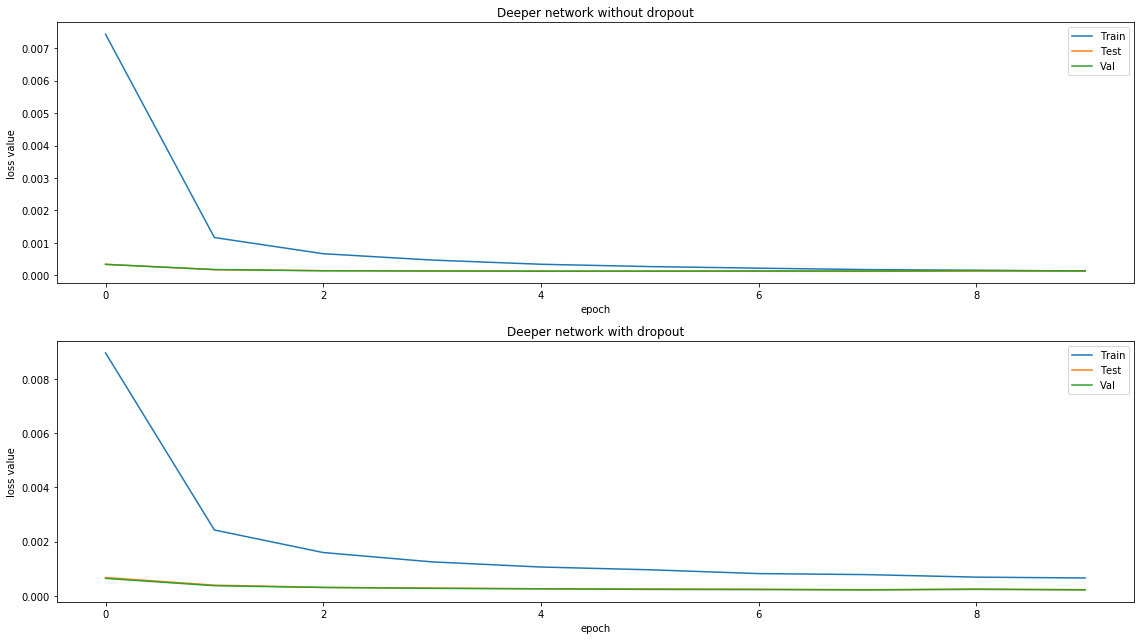

Without dropout accuracy: Train 0.95778, Test 0.9411, Val 0.9431
Dropout accuracy: Train 0.95602, Test 0.9417, Val 0.9422


In [67]:
import time
optimizer_config = {'learning_rate': 1e-3, 'beta1': 0.9, 'beta2':0.999, 'epsilon':1e-8}
batch_size = 128

criterion = ClassNLLCriterion()
n_epoch = 10

X = X_train_transformed
y = y_train

a = ReLU
net = Sequential()
net.add(Linear(X.shape[1], 100))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(100))
net.add(a())        
net.add(Linear(100, 50))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(50))
net.add(a())
net.add(Linear(50, y.shape[1]))
net.add(LogSoftMax())

losses_without_dropout = {
    'train': [],
    'test': [],
    'val': [],
}
times_without_dropout = []

optimizer_state = {}

for i in range(n_epoch):
    start = time.time()
    summary_loss = 0.0
    for x_batch, y_batch in get_batches((X, y), batch_size):
        net.zeroGradParameters()
        pred = net.forward(x_batch)
        loss = criterion.forward(pred, y_batch)
        summary_loss += loss
        dp = criterion.backward(pred, y_batch)
        net.backward(x_batch, dp)
        adam_optimizer(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
    end = time.time()
    times_without_dropout.append(end - start)
    losses_without_dropout['train'].append(summary_loss / X.shape[0])
    
    summary_loss = 0.0
    for x_batch, y_batch in get_batches((X_val_transformed, y_val), batch_size):
        net.zeroGradParameters()
        pred = net.forward(x_batch)
        loss = criterion.forward(pred, y_batch)
        summary_loss += loss  
    
    losses_without_dropout['val'].append(summary_loss / X.shape[0])
    
    summary_loss = 0.0
    for x_batch, y_batch in get_batches((X_test_transformed, y_test), batch_size):
        net.zeroGradParameters()
        pred = net.forward(x_batch)
        loss = criterion.forward(pred, y_batch)
        summary_loss += loss  
    
    losses_without_dropout['test'].append(summary_loss / X.shape[0])
    
net.evaluate()
y_pred = np.argmax(net.forward(X_train_transformed), axis = 1)
y_true = np.argmax(y_train, axis = 1)
without_dropout_train_accuracy = (y_true == y_pred).mean()    
    
net.evaluate()
y_pred = np.argmax(net.forward(X_test_transformed), axis = 1)
y_true = np.argmax(y_test, axis = 1)
without_dropout_test_accuracy = (y_true == y_pred).mean()

net.evaluate()
y_pred = np.argmax(net.forward(X_val_transformed), axis = 1)
y_true = np.argmax(y_val, axis = 1)
without_dropout_val_accuracy = (y_true == y_pred).mean()


a = ReLU
net = Sequential()
net.add(Linear(X.shape[1], 100))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(100))
net.add(a())        
net.add(Linear(100, 50))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(50))
net.add(a())
net.add(Dropout())
net.add(Linear(50, y.shape[1]))
net.add(LogSoftMax())

losses_with_dropout = {
    'train': [],
    'test': [],
    'val': [],
}
times_with_dropout = []

optimizer_state = {}

for i in range(n_epoch):
    start = time.time()
    summary_loss = 0.0
    for x_batch, y_batch in get_batches((X, y), batch_size):
        net.zeroGradParameters()
        pred = net.forward(x_batch)
        loss = criterion.forward(pred, y_batch)
        summary_loss += loss
        dp = criterion.backward(pred, y_batch)
        net.backward(x_batch, dp)
        adam_optimizer(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
    end = time.time()
    times_with_dropout.append(end - start)
    losses_with_dropout['train'].append(summary_loss / X.shape[0])
    
    summary_loss = 0.0
    for x_batch, y_batch in get_batches((X_val_transformed, y_val), batch_size):
        net.zeroGradParameters()
        pred = net.forward(x_batch)
        loss = criterion.forward(pred, y_batch)
        summary_loss += loss  
    
    losses_with_dropout['val'].append(summary_loss / X.shape[0])
    
    summary_loss = 0.0
    for x_batch, y_batch in get_batches((X_test_transformed, y_test), batch_size):
        net.zeroGradParameters()
        pred = net.forward(x_batch)
        loss = criterion.forward(pred, y_batch)
        summary_loss += loss  
    
    losses_with_dropout['test'].append(summary_loss / X.shape[0])

net.evaluate()
y_pred = np.argmax(net.forward(X_train_transformed), axis = 1)
y_true = np.argmax(y_train, axis = 1)
dropout_train_accuracy = (y_true == y_pred).mean()    
    
net.evaluate()
y_pred = np.argmax(net.forward(X_test_transformed), axis = 1)
y_true = np.argmax(y_test, axis = 1)
dropout_test_accuracy = (y_true == y_pred).mean()

net.evaluate()
y_pred = np.argmax(net.forward(X_val_transformed), axis = 1)
y_true = np.argmax(y_val, axis = 1)
dropout_val_accuracy = (y_true == y_pred).mean()
    
plt.figure(figsize=(16,9))

plt.subplot(2,1,1)

plt.plot(losses_without_dropout['train'])
plt.plot(losses_without_dropout['test'])
plt.plot(losses_without_dropout['val'])
plt.title('Deeper network without dropout')
plt.xlabel("epoch")
plt.ylabel("loss value")
plt.legend(['Train', 'Test', 'Val'])

plt.subplot(2,1,2)

plt.plot(losses_with_dropout['train'])
plt.plot(losses_with_dropout['test'])
plt.plot(losses_with_dropout['val'])
plt.title('Deeper network with dropout')
plt.xlabel("epoch")
plt.ylabel("loss value")
plt.legend(['Train', 'Test', 'Val'])

plt.tight_layout()
plt.show()

print("Without dropout accuracy: Train {}, Test {}, Val {}".format(without_dropout_train_accuracy, without_dropout_test_accuracy, without_dropout_val_accuracy))
print("Dropout accuracy: Train {}, Test {}, Val {}".format(dropout_train_accuracy, dropout_test_accuracy, dropout_val_accuracy))

## Comments
- Increase the number of parameters in the network. Try inserting the Dropout layer.
We can't see here the big increase in terms of model's quality, but with dropout train loss decreases slower and in the end it's bigger than the one without dropout. At the same time accuracy on test is slightly bigger, so we can argue that dropout helps with overfitting (in this case, of course it can be just random noise)

# Learning embeddings

**Finally**, use the Contrastive criterion instead of the NLLCriterion to train the embeddings. 
Using the code below, compute the pairwise distances and show the distance histograms for the validation set (or its part). Compute the Bhattacharyya coefficient using the outputs of the plt.hist: $ BC(p,q) = \sum (\sqrt{p_i q_i}) $.

Repeat this for the embeddings trained with the NLLCriterion, compare the results. You may want to try different margins $M$ (hint: $M=10$ should be okay).

 ***3 points***

### With Contrastive criterion

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


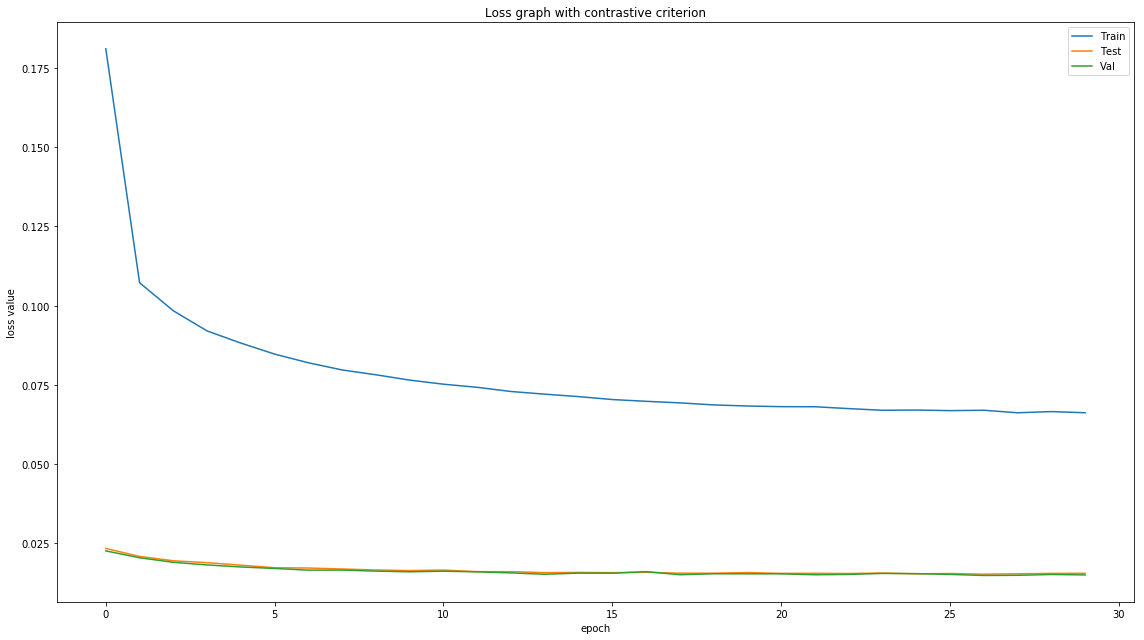

In [10]:
import time
optimizer_config = {'learning_rate': 1e-3, 'beta1': 0.9, 'beta2':0.999, 'epsilon':1e-8}
batch_size = 128

criterion = ClassContrastiveCriterion(M=10)
n_epoch = 30

X = X_train_transformed
y = y_train

a = ReLU
net = Sequential()
net.add(Linear(X.shape[1], 100))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(100))
net.add(a())        
net.add(Linear(100, 50))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(50))
net.add(a())
net.add(Dropout())
net.add(Linear(50, y_train.shape[1]))
net.add(LogSoftMax())

losses_with_dropout = {
    'train': [],
    'test': [],
    'val': [],
}
times_with_dropout = []

optimizer_state = {}

for i in range(n_epoch):
    print(i)
    start = time.time()
    summary_loss = 0.0
    for x_batch, y_batch in get_batches((X, y), batch_size):
        net.zeroGradParameters()
        pred = net.forward(x_batch)
        loss = criterion.forward(pred, np.squeeze(one_hot_obj.inverse_transform(y_batch)))
        summary_loss += loss
        dp = criterion.backward(pred, np.squeeze(one_hot_obj.inverse_transform(y_batch)))
        net.backward(x_batch, dp)
        adam_optimizer(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
    end = time.time()
    times_with_dropout.append(end - start)
    losses_with_dropout['train'].append(summary_loss / X.shape[0])
    
    summary_loss = 0.0
    for x_batch, y_batch in get_batches((X_val_transformed, y_val), batch_size):
        net.zeroGradParameters()
        pred = net.forward(x_batch)
        loss = criterion.forward(pred, np.squeeze(one_hot_obj.inverse_transform(y_batch)))
        summary_loss += loss  
    
    losses_with_dropout['val'].append(summary_loss / X.shape[0])
    
    summary_loss = 0.0
    for x_batch, y_batch in get_batches((X_test_transformed, y_test), batch_size):
        net.zeroGradParameters()
        pred = net.forward(x_batch)
        loss = criterion.forward(pred, np.squeeze(one_hot_obj.inverse_transform(y_batch)))
        summary_loss += loss  
    
    losses_with_dropout['test'].append(summary_loss / X.shape[0])

plt.figure(figsize=(16,9))
plt.plot(losses_with_dropout['train'])
plt.plot(losses_with_dropout['test'])
plt.plot(losses_with_dropout['val'])
plt.title('Loss graph with contrastive criterion')
plt.xlabel("epoch")
plt.ylabel("loss value")
plt.legend(['Train', 'Test', 'Val'])

plt.tight_layout()
plt.show()

In [11]:
net.evaluate()
y_pred = np.argmax(net.forward(X_test_transformed), axis = 1)
y_true = np.argmax(y_test, axis = 1)
dropout_test_accuracy = (y_true == y_pred).mean()
print("Test accuracy {}".format(dropout_test_accuracy))

Test accuracy 0.017


In [12]:
X_val_slice = X_val_transformed[:5000]
y_val_slice = y_val[:5000]
net.forward(X_val_slice)

array([[ -2.00235332,  -3.05653924,  -9.23406644, ...,  -2.56944623,
         -4.4235768 ,  -0.38484031],
       [ -3.93331098,  -5.87442105,  -8.7683918 , ...,  -4.7235808 ,
         -6.03164955,  -2.730903  ],
       [ -4.20541277,  -9.12808667,  -3.13403065, ...,  -5.92477898,
         -5.78930767,  -3.47675038],
       ...,
       [ -2.36457944,  -6.24233456,  -3.62940903, ...,  -3.75951414,
         -4.21053762,  -1.24089917],
       [ -6.99267713, -11.60032809,  -6.8717703 , ...,  -8.71449435,
         -8.77841995,  -6.10046719],
       [ -2.14719785,  -5.7152316 ,  -4.19608594, ...,  -3.47138855,
         -4.11323818,  -0.85225871]])

1250189.0 11247311.0
Bhattacharyya value 0.6132296027688037


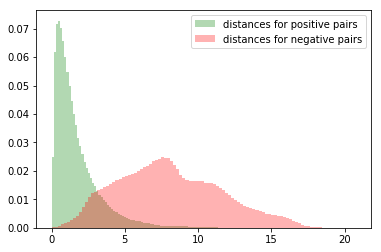

In [13]:
#features : 'number of examples' * 'dimensionality'
f = net[-2].output
labels = np.squeeze(one_hot_obj.inverse_transform(y_val_slice))

import scipy.spatial
#compute pairwise distances
d = scipy.spatial.distance_matrix(f,f)
#extract distances for the 'positive pairs' (same class), 
#extract distances for the 'negarite pairs' (different classes), 
a = np.tile(labels.reshape(len(labels), 1), (1, len(labels)))
b =np.tile(labels.reshape(1, len(labels)), (len(labels), 1))
#labels
c = np.zeros((len(labels), len(labels)))
c[a==b]=1
pind =  np.triu(c, k=1)

c = np.zeros((len(labels), len(labels)))
c[a!=b]=1
nind =  np.triu(c, k=1)

print(np.sum(pind), np.sum(nind))


pd = d[pind == 1]
nd = d[nind == 1]

hp,_,_ =plt.hist(pd, bins=100, color='green', alpha = 0.3, weights = np.ones(len(pd))/len(pd), label = 'distances for positive pairs')
hn,_,_ =plt.hist(nd, bins=100, color='red', alpha = 0.3, weights = np.ones(len(nd))/len(nd),label = 'distances for negative pairs')
plt.legend(loc='best')

bhattacharyya = np.sum(np.sqrt(hp*hn))
print("Bhattacharyya value {}".format(bhattacharyya))

### With NLL criterion

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


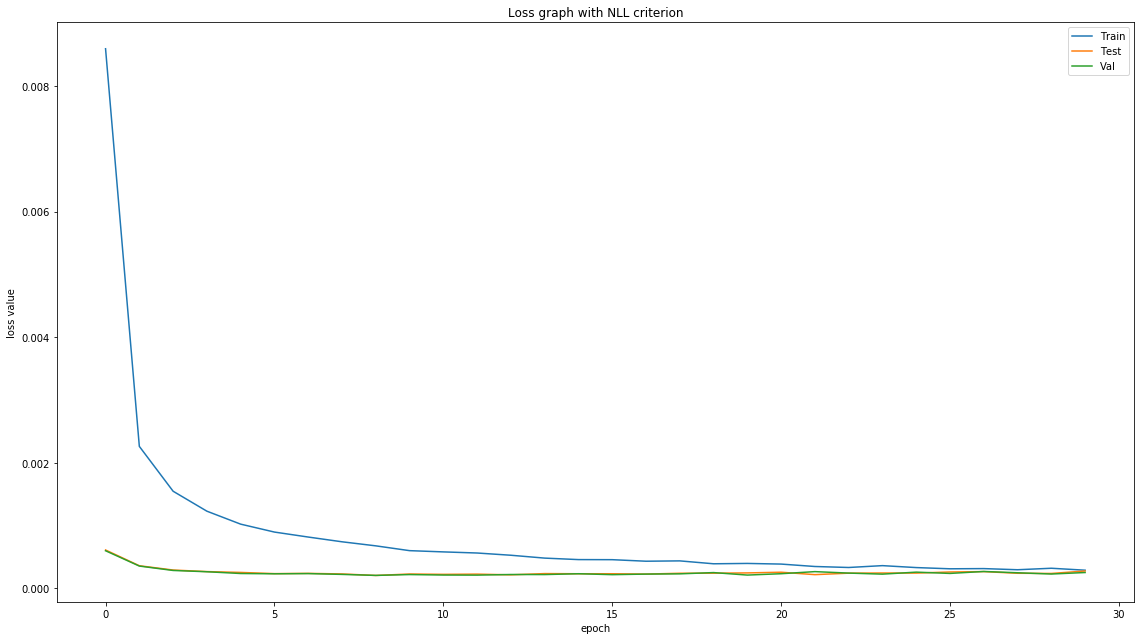

In [18]:
import time
optimizer_config = {'learning_rate': 1e-3, 'beta1': 0.9, 'beta2':0.999, 'epsilon':1e-8}
batch_size = 128

criterion = ClassNLLCriterion()
n_epoch = 30

X = X_train_transformed
y = y_train

a = ReLU
net = Sequential()
net.add(Linear(X.shape[1], 100))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(100))
net.add(a())        
net.add(Linear(100, 50))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(50))
net.add(a())
net.add(Dropout())
net.add(Linear(50, y_train.shape[1]))
net.add(LogSoftMax())

losses_with_dropout = {
    'train': [],
    'test': [],
    'val': [],
}
times_with_dropout = []

optimizer_state = {}

for i in range(n_epoch):
    print(i)
    start = time.time()
    summary_loss = 0.0
    for x_batch, y_batch in get_batches((X, y), batch_size):
        net.zeroGradParameters()
        pred = net.forward(x_batch)
        loss = criterion.forward(pred, y_batch)
        summary_loss += loss
        dp = criterion.backward(pred, y_batch)
        net.backward(x_batch, dp)
        adam_optimizer(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
    end = time.time()
    times_with_dropout.append(end - start)
    losses_with_dropout['train'].append(summary_loss / X.shape[0])
    
    summary_loss = 0.0
    for x_batch, y_batch in get_batches((X_val_transformed, y_val), batch_size):
        net.zeroGradParameters()
        pred = net.forward(x_batch)
        loss = criterion.forward(pred, y_batch)
        summary_loss += loss  
    
    losses_with_dropout['val'].append(summary_loss / X.shape[0])
    
    summary_loss = 0.0
    for x_batch, y_batch in get_batches((X_test_transformed, y_test), batch_size):
        net.zeroGradParameters()
        pred = net.forward(x_batch)
        loss = criterion.forward(pred, y_batch)
        summary_loss += loss  
    
    losses_with_dropout['test'].append(summary_loss / X.shape[0])

plt.figure(figsize=(16,9))
plt.plot(losses_with_dropout['train'])
plt.plot(losses_with_dropout['test'])
plt.plot(losses_with_dropout['val'])
plt.title('Loss graph with NLL criterion')
plt.xlabel("epoch")
plt.ylabel("loss value")
plt.legend(['Train', 'Test', 'Val'])

plt.tight_layout()
plt.show()

In [19]:
net.evaluate()
y_pred = np.argmax(net.forward(X_test_transformed), axis = 1)
y_true = np.argmax(y_test, axis = 1)
dropout_test_accuracy = (y_true == y_pred).mean()
print("Test accuracy {}".format(dropout_test_accuracy))

Test accuracy 0.9669


In [20]:
X_val_slice = X_val_transformed[:5000]
y_val_slice = y_val[:5000]
net.forward(X_val_slice)

array([[-5.70540015e+01, -5.30644675e+01, -3.75265433e+01, ...,
        -4.89601479e+01, -4.29587744e+01, -4.79047753e+01],
       [-2.08023908e+01, -2.28901258e+01, -1.39110725e+01, ...,
        -2.35096771e+01, -3.30586787e-06, -2.05930772e+01],
       [-1.30143643e+01, -1.61177315e+01, -1.40181265e+01, ...,
        -1.48057674e+01, -1.16285348e+01, -1.65876953e+01],
       ...,
       [-2.48947485e-07, -2.18403005e+01, -1.53617504e+01, ...,
        -2.35736700e+01, -2.02181762e+01, -2.62903002e+01],
       [-2.29334293e+01, -2.54930538e+01, -1.81689407e+01, ...,
        -1.95622512e+01, -2.21318657e+01, -2.00055263e+01],
       [-7.11435359e-08, -2.21966260e+01, -1.77198098e+01, ...,
        -1.71385576e+01, -2.17136102e+01, -2.61007353e+01]])

1250189.0 11247311.0
Bhattacharyya value 0.6306235996182401


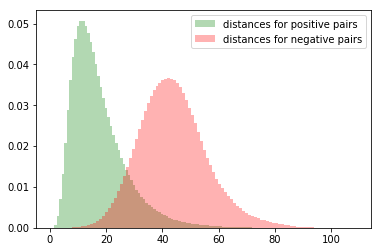

In [21]:
#features : 'number of examples' * 'dimensionality'
f = net[-2].output
labels = np.squeeze(one_hot_obj.inverse_transform(y_val_slice))

import scipy.spatial
#compute pairwise distances
d = scipy.spatial.distance_matrix(f,f)
#extract distances for the 'positive pairs' (same class), 
#extract distances for the 'negarite pairs' (different classes), 
a = np.tile(labels.reshape(len(labels), 1), (1, len(labels)))
b =np.tile(labels.reshape(1, len(labels)), (len(labels), 1))
#labels
c = np.zeros((len(labels), len(labels)))
c[a==b]=1
pind =  np.triu(c, k=1)

c = np.zeros((len(labels), len(labels)))
c[a!=b]=1
nind =  np.triu(c, k=1)

print(np.sum(pind), np.sum(nind))


pd = d[pind == 1]
nd = d[nind == 1]

hp,_,_ =plt.hist(pd, bins=100, color='green', alpha = 0.3, weights = np.ones(len(pd))/len(pd), label = 'distances for positive pairs')
hn,_,_ =plt.hist(nd, bins=100, color='red', alpha = 0.3, weights = np.ones(len(nd))/len(nd),label = 'distances for negative pairs')
plt.legend(loc='best')

bhattacharyya = np.sum(np.sqrt(hp*hn))
print("Bhattacharyya value {}".format(bhattacharyya))

## Comments
So, it looks like Constrative criterion really works. Indeed, distances between positive elements became lower and at the same time histogram for negative elements look wider (tends to big distance values). And it's also seems like with constrative loss the network learns much slower or reaches the local non-optimal minimum. If we look on the accuracy we'll see that something is wrong...